In [ ]:
# 1. 挂载 Google Drive
from google.colab import drive
import os

drive.mount('/content/drive/')

# ==========================================
# 【重要】路径设置
# ==========================================
DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/g3s3_bigdata/data'

if os.path.exists(os.path.join(DATA_PATH, 'train.csv')):
    print("成功找到 train.csv！路径正确。")
else:
    print(f"错误：在 {DATA_PATH} 下没找到 train.csv。请检查路径或文件名。")

Mounted at /content/drive/
成功找到 train.csv！路径正确。


Using device: cuda
Reading data from /content/drive/MyDrive/Colab_Notebooks/g3s3_bigdata/data...
Data loaded successfully.
Splitting data by Feature_7 groups...
Train size: 36006 (90.02%)
Val size: 3994 (9.98%)
Building Datasets...
Start Training (Strategy 1: Daily Prediction Only)...
Epoch 1/30 | Train Loss: 206498.06671847 | Val Loss: 193613.37847222
Epoch 2/30 | Train Loss: 181105.33597913 | Val Loss: 169347.90897817
Epoch 3/30 | Train Loss: 157681.09907860 | Val Loss: 146793.47346230
Epoch 4/30 | Train Loss: 135961.32529418 | Val Loss: 125933.89992560
Epoch 5/30 | Train Loss: 115952.43253219 | Val Loss: 106777.09610615
Epoch 6/30 | Train Loss: 97644.95552564 | Val Loss: 89311.02380952
Epoch 7/30 | Train Loss: 81034.90271148 | Val Loss: 73530.81485615
Epoch 8/30 | Train Loss: 66107.38830762 | Val Loss: 59422.87065972
Epoch 9/30 | Train Loss: 52858.05751832 | Val Loss: 46984.29055060
Epoch 10/30 | Train Loss: 41272.04952542 | Val Loss: 36194.32266865
Epoch 11/30 | Train Loss: 31329.6

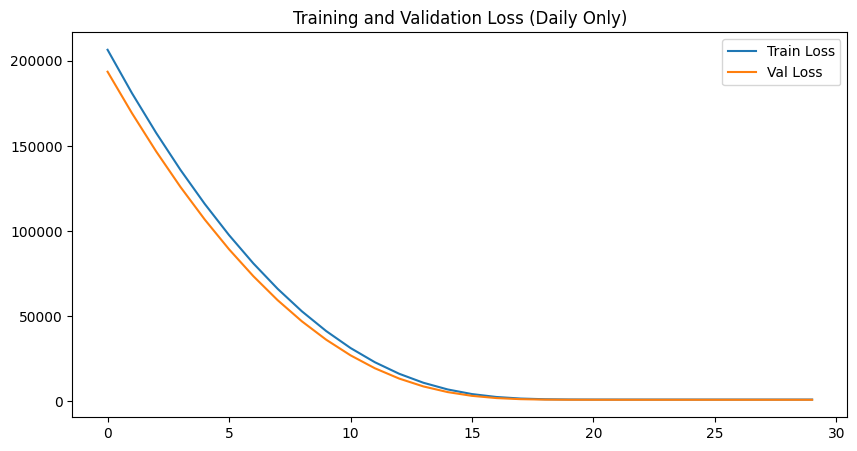

Model saved to /content/drive/MyDrive/Colab_Notebooks/g3s3_bigdata/data/winton_model_daily.pth


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import time

# --- 配置参数 ---
BATCH_SIZE = 64


###################
LEARNING_RATE = 1e-5
EPOCHS = 30
####################


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# ==========================================
# 1. Dataset 定义 (Strategy 1: 只关注 Daily Target)
# ==========================================
class WintonDataset(Dataset):
    def __init__(self, df, mode='train', scaler=None):
        self.mode = mode

        # A. 序列特征 (119分钟: Ret_2 ~ Ret_120)
        seq_cols = [f'Ret_{i}' for i in range(2, 121)]
        self.seq_data = df[seq_cols].fillna(0).values.astype(np.float32)
        self.seq_data = self.seq_data[:, :, None] # [N, 119, 1]

        # B. 静态特征 (只保留 Ret_MinusTwo, Ret_MinusOne)
        feat_cols = ['Ret_MinusTwo', 'Ret_MinusOne']
        static_raw = df[feat_cols].fillna(0).values.astype(np.float32)

        # 归一化
        if scaler is None:
            self.scaler = StandardScaler()
            self.static_data = self.scaler.fit_transform(static_raw)
        else:
            self.scaler = scaler
            self.static_data = self.scaler.transform(static_raw)

        if self.mode == 'train':
            # C. 预测目标 (只取 2 个日级目标!)
            target_daily_cols = ['Ret_PlusOne', 'Ret_PlusTwo']
            self.targets = df[target_daily_cols].fillna(0).values.astype(np.float32)

            # D. 权重 (只取 Daily Weight)
            self.w_daily = df['Weight_Daily'].fillna(0).values.astype(np.float32)

    def __len__(self):
        return len(self.seq_data)

    def __getitem__(self, idx):
        if self.mode == 'train':
            # 注意：不再返回 w_intra
            return (self.seq_data[idx], self.static_data[idx], self.targets[idx], self.w_daily[idx])
        else:
            return (self.seq_data[idx], self.static_data[idx])

# ==========================================
# 2. 模型定义 (Strategy 1: Output Dim = 2)
# ==========================================
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x_pad = torch.cat([front, x, end], dim=1)
        x_pad = x_pad.permute(0, 2, 1)
        trend = self.avg(x_pad)
        trend = trend.permute(0, 2, 1)
        seasonal = x - trend
        return seasonal, trend

class WintonDLinear(nn.Module):
    def __init__(self, seq_len=119, pred_len=2, static_dim=2, kernel_size=25):
        # 注意 pred_len=2 (只预测 Daily), static_dim=2 (只用两个Ret特征)
        super(WintonDLinear, self).__init__()
        self.decomposition = SeriesDecomp(kernel_size=kernel_size)

        self.Linear_Seasonal = nn.Linear(seq_len, pred_len)
        self.Linear_Trend = nn.Linear(seq_len, pred_len)
        # Static path now uses a small MLP before outputting daily preds
        self.Static_MLP = nn.Sequential(
            nn.Linear(static_dim, 8),
            nn.ReLU(),
            nn.Linear(8, pred_len),
        )

        # 初始化权重
        self.Linear_Seasonal.weight.data.normal_(0, 0.01)
        self.Linear_Trend.weight.data.normal_(0, 0.01)
        for layer in self.Static_MLP:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(0, 0.01)

    def forward(self, x_seq, x_static):
        seasonal_init, trend_init = self.decomposition(x_seq)
        seasonal_init = seasonal_init.squeeze(-1)
        trend_init = trend_init.squeeze(-1)

        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)
        static_output = self.Static_MLP(x_static)

        return seasonal_output + trend_output + static_output

# ==========================================
# 3. 损失函数 (Strategy 1: Only Daily Loss)
# ==========================================
class WintonDailyLoss(nn.Module):
    def __init__(self):
        super(WintonDailyLoss, self).__init__()

    def forward(self, pred, target, w_daily):
        # pred, target: [Batch, 2]
        # w_daily: [Batch]

        # 计算 Daily Loss (MSE * Weight)
        loss_daily = torch.mean((pred - target)**2, dim=1) * w_daily
        return torch.mean(loss_daily)


# ==========================================
# 4. 训练流程
# ==========================================
print(f"Reading data from {DATA_PATH}...")
train_file = os.path.join(DATA_PATH, 'train.csv')

try:
    df = pd.read_csv(train_file)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: train.csv not found!")
    raise

# ==========================================
# Use GroupKFold split by Feature_7
# n_splits=10 gives ~90% train, ~10% validation
# ==========================================
print("Splitting data by Feature_7 groups...")
groups = df['Feature_7'].values
gkf = GroupKFold(n_splits=10)

# Get the first split (we only need one train/val split)
train_idx, val_idx = next(gkf.split(df, groups=groups))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.2f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.2f}%)")

print("Building Datasets...")
train_dataset = WintonDataset(train_df, mode='train')
val_dataset = WintonDataset(val_df, mode='train', scaler=train_dataset.scaler)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 初始化模型 (pred_len=2, static_dim=2)
model = WintonDLinear(seq_len=119, pred_len=2, static_dim=2).to(DEVICE)
criterion = WintonDailyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Start Training (Strategy 1: Daily Prediction Only)...")
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []

    for seq_x, stat_x, targets, w_d in train_loader:
        # 数据移至 GPU
        seq_x, stat_x = seq_x.to(DEVICE), stat_x.to(DEVICE)
        targets = targets.to(DEVICE)
        w_d = w_d.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(seq_x, stat_x)
        loss = criterion(outputs, targets, w_d)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    # 验证
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for seq_x, stat_x, targets, w_d in val_loader:
            seq_x, stat_x = seq_x.to(DEVICE), stat_x.to(DEVICE)
            targets = targets.to(DEVICE)
            w_d = w_d.to(DEVICE)

            outputs = model(seq_x, stat_x)
            loss = criterion(outputs, targets, w_d)
            val_batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    avg_val_loss = np.mean(val_batch_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.8f} | Val Loss: {avg_val_loss:.8f}")

# 绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss (Daily Only)')
plt.legend()
plt.show()

# 保存模型
save_path = os.path.join(DATA_PATH, 'winton_model_daily.pth')
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

In [ ]:
# ==========================================
# 5. 预测与提交 (Zeroing out Intraday)
# ==========================================
print("Loading Test Data...")
test_file = os.path.join(DATA_PATH, 'test_2.csv')
test_df = pd.read_csv(test_file)

test_dataset = WintonDataset(test_df, mode='test', scaler=train_dataset.scaler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
all_preds = []

print("Predicting...")
with torch.no_grad():
    for seq_x, stat_x in test_loader:
        seq_x = seq_x.to(DEVICE)
        stat_x = stat_x.to(DEVICE)

        # output shape: [Batch, 2]
        outputs = model(seq_x, stat_x)
        all_preds.append(outputs.cpu().numpy())

predictions = np.concatenate(all_preds, axis=0) # [N_test, 2]

print("Formatting submission...")
ids = test_df['Id'].values if 'Id' in test_df.columns else np.arange(1, len(test_df)+1)

submission_rows = []
for idx, row_preds in enumerate(predictions):
    current_id = ids[idx]

    # 1. 分钟级预测 (1-60): 全部填 0
    for i in range(60):
        submission_rows.append([f"{current_id}_{i+1}", 0.0])

    # 2. 日级预测 (61, 62): 填模型预测值
    # row_preds[0] -> Ret_PlusOne
    # row_preds[1] -> Ret_PlusTwo
    submission_rows.append([f"{current_id}_61", row_preds[0]])
    submission_rows.append([f"{current_id}_62", row_preds[1]])

sub_df = pd.DataFrame(submission_rows, columns=['Id', 'Predicted'])

# 保存到 Drive
sub_save_path = os.path.join(DATA_PATH, 'daily_only_linear_MLP_final_try.csv')
sub_df.to_csv(sub_save_path, index=False)

print(f"Done! Submission file saved to {sub_save_path}")

Loading Test Data...
Predicting...
Formatting submission...
Done! Submission file saved to /content/drive/MyDrive/Colab_Notebooks/g3s3_bigdata/data/daily_only_linear_MLP_final_try.csv
